# MLP from scratch

In this homework, you will code a [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) with one hidden layer to classify text data.

Advice:
- As much as possible, please try to make matrix and vector operations (good practice for efficient code)
- If you're not familiar with numpy, check the documentation of `np.max`, `np.clip`, `np.random.randn`, `np.reshape`. FYI the matrix multiplication operator is `@`, and you may want to learn about [broadcasting rules](https://numpy.org/doc/stable/user/basics.broadcasting.html) to see how it deals with tensor operations of different sizes
- You can also check about `torch.clamp`, `torch.nn.Parameter`

## 1. Some utilities and dataset for Part 2

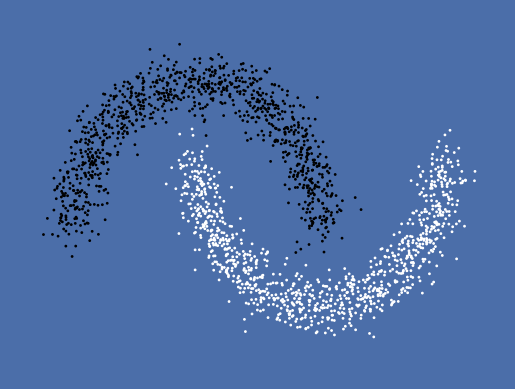

Epoch 1/100, Loss: 0.6796521716940078
Epoch 2/100, Loss: 10.355442366663532
Epoch 3/100, Loss: 7.046582489932066
Epoch 4/100, Loss: 4.2933642666815475
Epoch 5/100, Loss: 3.5678390888806106
Epoch 6/100, Loss: 2.8997185596081763
Epoch 7/100, Loss: 3.0658460014994473
Epoch 8/100, Loss: 2.6852947187844327
Epoch 9/100, Loss: 3.4443730419279777
Epoch 10/100, Loss: 3.2125750490332012
Epoch 11/100, Loss: 2.6047703412725594
Epoch 12/100, Loss: 2.7230004503119902
Epoch 13/100, Loss: 3.1420594364300687
Epoch 14/100, Loss: 3.1921920754180504
Epoch 15/100, Loss: 2.775890485209574
Epoch 16/100, Loss: 4.833194196662208
Epoch 17/100, Loss: 3.4226327387814703
Epoch 18/100, Loss: 2.9025788494440787
Epoch 19/100, Loss: 2.517889355931653
Epoch 20/100, Loss: 3.1961797600243287
Epoch 21/100, Loss: 2.509808125230894
Epoch 22/100, Loss: 2.806564325620446
Epoch 23/100, Loss: 2.752606498117768
Epoch 24/100, Loss: 2.686527545263174
Epoch 25/100, Loss: 3.335884297252371
Epoch 26/100, Loss: 2.5968310129546768
Epoc

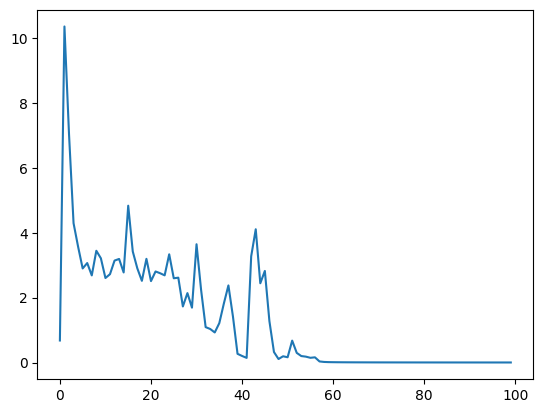

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Generate and plot the data
def plot_data(ax, X, Y):
     plt.axis('off')
     ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap='bone')

X, Y = make_moons(n_samples=2000, noise=0.1)

x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_data(ax, X, Y)
plt.show()

# Define the layers
class Linear:
     def __init__(self, input_dim: int, output_dim: int):
         self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(2. / input_dim)
         self.bias = np.zeros((1, output_dim))

     def forward(self, X: np.ndarray):
         self.X = X
         return X @ self.weights + self.bias

     def backward(self, grad: np.ndarray):
         self.grad_w = self.X.T @ grad
         self.grad_b = np.sum(grad, axis=0)
         return grad @ self.weights.T

     def step(self, learning_rate: float):
         self.weights -= learning_rate * self.grad_w
         self.bias -= learning_rate * self.grad_b

class ReLU:
     def forward(self, X: np.ndarray):
         self.X = X
         return np.maximum(0, X)

     def backward(self, grad: np.ndarray):
         return grad * (self.X > 0)

     def step(self, learning_rate: float):
         pass

class Sigmoid:
    def forward(self, X: np.ndarray):
        self.X = X
        return 1 / (1 + np.exp(-X))

    def backward(self, grad: np.ndarray):
        sigmoid = self.forward(self.X)
        return grad * sigmoid * (1 - sigmoid)

    def step(self, learning_rate: float):
        pass

# Define the model
class Sequential:
     def __init__(self, *args):
         self.layers = args

     def forward(self, X: np.ndarray):
         for layer in self.layers:
             X = layer.forward(X)
         return X

     def backward(self, grad: np.ndarray):
         for layer in reversed(self.layers):
             grad = layer.backward(grad)

     def step(self, learning_rate: float):
         for layer in self.layers:
             layer.step(learning_rate)

     def train(self, X: np.ndarray, y: np.ndarray, epochs: int, learning_rate: float):
         history = []

         for i in range(epochs):
             y_pred = self.forward(X)
             loss = self.binary_cross_entropy(y, y_pred)
             print(f'Epoch {i+1}/{epochs}, Loss: {loss}')
             history.append(loss)
             grad = self.grad_binary_cross_entropy(y, y_pred)
             self.backward(grad)
             self.step(learning_rate)

         return history

     @staticmethod
     def binary_cross_entropy(y: np.ndarray, y_pred: np.ndarray):
         epsilon = 1e-12 # to avoid taking log of zero
         return -np.mean(y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon))

     @staticmethod
     def grad_binary_cross_entropy(y: np.ndarray, y_pred: np.ndarray):
         epsilon = 1e-12 # to avoid division by zero
         return - (y / (y_pred + epsilon)) + ((1 - y) / (1 - y_pred + epsilon))

# Instantiate the model
model = Sequential(
     Linear(2, 64),
     ReLU(),
     Linear(64, 1),
     Sigmoid(),
)

# Reshape the target variable to be a 2D array
Y = Y.reshape(-1, 1)

# Train the model
history = model.train(X, Y, epochs=100, learning_rate=0.01)

# Plot loss history
plt.plot(history)
plt.show()

In [65]:
# Define the grid on which we will evaluate our classifier
xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                     np.arange(y_min, y_max, .1))

to_forward = np.array(list(zip(xx.ravel(), yy.ravel())))

# plot the decision boundary of our classifier
def plot_decision_boundary(ax, X, Y, classifier):
    Z = classifier.forward(to_forward)
    Z = Z.ravel().reshape(xx.shape)  # Flatten Z before reshaping
    
    ax.contourf(xx, yy, Z>0.5, cmap='Blues')
    plot_data(ax, X,Y)

## 2. MLP in numpy

Here you need to code your implementation of the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation and the [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function).

In [95]:
class MyReLU(object):
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
        
    def backward(self, grad_output):
        return (self.x > 0) * grad_output
    
    def step(self, learning_rate):
        pass

class MySigmoid(object):
    def forward(self, x):
        self.x = x
        self.y = 1 / (1 + np.exp(-x))
        return self.y.ravel()
    
    def backward(self, grad_output):
        return self.y * (1 - self.y) * grad_output
    
    def step(self, learning_rate):
        pass

Probably a good time to test your functions...

In [96]:
test_relu = MyReLU()
# Convert list to np array
input_data = np.array([0, -1, 0.5, -0.5, 0.8, 1])
test_relu.forward(input_data)

array([0. , 0. , 0.5, 0. , 0.8, 1. ])

In [97]:
# Also provide a np array for backward
grad_output = np.ones(input_data.shape)
test_relu.backward(grad_output)

array([0., 0., 1., 0., 1., 1.])

In [98]:
test_sig = MySigmoid()

test_sig.forward(np.ones(1))

array([0.73105858])

In [99]:
test_sig.backward(np.ones(1))

array([0.19661193])

A bit more complicated, you need now to implement your linear layer i.e. multiplication by a matrix W and summing with a bias b.

In [100]:
class MyLinear(object):
    def __init__(self, n_input, n_output):
        self.W = np.random.randn(n_output, n_input)
        self.b = np.random.randn(n_output)
    
    def forward(self, x):
        self.x = x
        return np.dot(self.W, x.T).T + self.b 
    
    def backward(self, grad_output):
        self.grad_W = np.outer(grad_output, self.x)
        self.grad_b = grad_output
        return np.dot(grad_output, self.W)
        
    def step(self, learning_rate):
        self.W -= learning_rate * self.grad_W
        self.b -= learning_rate * self.grad_b

Code your network. Note that with a Sigmoid layer, you should use the Binary Cross Entropy (BCE) loss.

In [101]:
class Sequential(object):
    def __init__(self, layers):
        self.layers = layers
    
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x.ravel() 
    
    def compute_loss(self, out, label):
        self.loss_grad = np.where(label == 1, -1 / (out + 1e-10), 1 / (1 - out + 1e-10))
        return -label * np.log(out + 1e-10) - (1 - label) * np.log(1 - out + 1e-10)
    
    def backward(self):
        grad = self.loss_grad
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad
    
    def step(self, learning_rate):
        for layer in self.layers:
            layer.step(learning_rate)

In [107]:
yourNetwork = Sequential([
    MyLinear(2, 10),
    MyReLU(),
    MyLinear(10, 1),
    MySigmoid(),
])

In [108]:
losses = []
learning_rate = 1e-2
epochs = 10
for epoch in range(epochs):
    for it in range(len(X)):
        idx = np.random.randint(0, len(X))
        x, y = X[idx], Y[idx]

        out = yourNetwork.forward(x)
        loss = yourNetwork.compute_loss(out, y)
        losses.append(loss)

        yourNetwork.backward()
        yourNetwork.step(learning_rate)


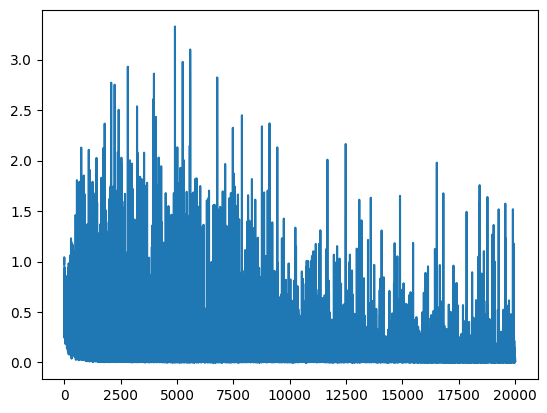

In [109]:
%matplotlib inline
plt.plot(losses)
plt.show()

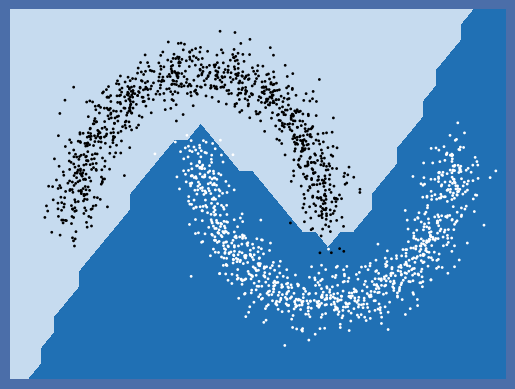

In [110]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
plot_decision_boundary(ax, X, Y, yourNetwork)
fig.canvas.draw()

## 3. Using a Pytorch module

In this last part, use `toch.nn.Module` to recode `MyLinear` and `MyReLU` so that these modules will be pytorch compatible.

## 3.1. Load & Preprocess the IMDB Dataset

In this section, you are required to read and load the provided `csv` file, and perform the preprocessing steps as specified in the assignment's description.

In [ ]:
# YOUR CODE HERE

## 3.2. MLP in torch

In [ ]:
import torch
import torch.nn as nn

# y = Wx + b
class MyLinear_mod(nn.Module):
    def __init__(self, n_input, n_output):
        super(MyLinear_mod, self).__init__()
        # define self.A and self.b the weights and biases
        # initialize them with a normal distribution
        # use nn.Parameters
        # YOUR CODE HERE
        raise NotImplementedError()

    def forward(self, x):
        # YOUR CODE HERE
        raise NotImplementedError()
        
class MyReLU_mod(nn.Module):
    def __init__(self):
        super(MyReLU_mod, self).__init__()
        
    def forward(self, x):
        # YOUR CODE HERE
        raise NotImplementedError()

Define your network using `MyLinear_mod`, `MyReLU_mod` and [`nn.Sigmoid`](https://pytorch.org/docs/stable/nn.html#sigmoid)

In [ ]:
# Define your dataloader here (specify your batch_size)
# Use:
from torch.utils.data import TensorDataset, DataLoader
# Note that you should transform your X, y to torch.Tensor

In [ ]:
# define your network with nn.Sequential
# use MyLinear_mod, MyReLU_mod and nn.Sigmoid (from pytorch)

# YOUR CODE HERE

raise NotImplementedError()

In [ ]:
from torch import optim

optimizer = optim.SGD(yourTorchNetwork.parameters(), lr=...)

losses = []
criterion = nn.BCELoss()
epochs = ...
for epoch in range(epochs):
    # You can print epoch No. and train/test accuracy here (after each epoch)
    for batch in yourTrainDataloader:
        # do a forward pass on the batch
        # YOUR CODE HERE
        raise NotImplementedError()

        # compute the loss according to your output and the label
        # YOUR CODE HERE
        raise NotImplementedError()

        # zero the gradients
        # YOUR CODE HERE
        raise NotImplementedError()

        # backward pass
        # YOUR CODE HERE
        raise NotImplementedError()

        # gradient step
        # YOUR CODE HERE
        raise NotImplementedError()

In [ ]:
plt.plot(losses)

In [ ]:
# print the classification_report